## (Optional) TPU configuration

To use [Cloud TPUs](https://cloud.google.com/tpu), first create a [TPU node](https://cloud.google.com/tpu/docs/creating-deleting-tpus#setup_TPU_only). Set the **TPU software version** to a matching PyTorch version (e.g. `pytorch-1.7`) and the **Network** to the same network used for your notebook instance (e.g. `datalab-network`).

Uncomment this section only if you are using TPUs. Note that you must be running this notebook on an [XLA](https://github.com/pytorch/xla) image such as [pytorch-xla.1-7](gcr.io/deeplearning-platform-release/pytorch-xla.1-7) for PyTorch to connect to Cloud TPUs. To use an XLA image, you can create a new notebook instance with the **Environment** set to `Custom container` and the **Docker container image** set to the XLA image location.

If you need a quota increase for Cloud TPUs, please review the [Cloud TPU Quota Policy](https://cloud.google.com/tpu/docs/quota) for more details.

### Review TPU configuration

Run the gcloud command to review the available TPUs for the one you wish to use.
Make note of the IP address (from NETWORK_ENDPOINT, without the port), and the # of TPU cores (derived from ACCELERATOR_TYPE). An ACCELERATOR_TYPE of v3-8 will indicate 8 TPU cores, for example.

In [1]:
# !gcloud compute tpus list --zone=YOUR_ZONE_HERE_SUCH_AS_us-central1-b

### Update TPU configuration

Update the IP address and cores variables here

In [2]:
# tpu_ip_address='10.1.2.3'
# tpu_cores=8

### Set TPU environment variables

In [3]:
# # TPU configuration
# %env XRT_TPU_CONFIG=tpu_worker;0;$tpu_ip_address:8470

# # Use bfloat16
# %env XLA_USE_BF16=1

In [4]:
import os
from multiprocessing import cpu_count

import lightning as L
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import torch
import torchvision
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.utilities.xla_device import XLADeviceUtils
if XLADeviceUtils.tpu_device_exists():
    import torch_xla

from task import train_model
from src.utils import get_datasets

plt.set_cmap("cividis")
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()


# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/VisionTransformers/")

# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/Users/albertomarengo/Bitstrapped-Project/PyTorch-Lightning/pytorch-venv/lib/python3.10/site-packages/pytorch_lightning/utilities/xla_device.py:60: LightningDeprecationWarning: `pytorch_lightning.utilities.xla_device.XLADeviceUtils.tpu_device_exists` has been deprecated in v1.8.0 and will be removed in v2.0.0. Please use `pytorch_lightning.accelerators.TPUAccelerator.is_available()` instead.
  rank_zero_deprecation(
Global seed set to 42


<Figure size 640x480 with 0 Axes>

In [5]:
world_size = int(os.environ["WORLD_SIZE"]) if "WORLD_SIZE" in os.environ else 1

In [6]:
world_size

1

In [7]:
# _ = !nproc
# tpu_cores = tpu_cores if 'tpu_cores' in vars() else 0
num_cpus = cpu_count()
num_gpus = torch.cuda.device_count()
device = torch.device('cuda') if num_gpus else 'cpu'

print(f'Device: {device}')
print(f'CPUs: {num_cpus}')
print(f'GPUs: {num_gpus}')
# print(f'TPUs: {tpu_cores}')

Device: cpu
CPUs: 8
GPUs: 0


In [8]:
if torch.cuda.is_available():
    trainer_num_workers = num_gpus
    dataloader_num_workers = num_gpus
else:
    trainer_num_workers = "auto"
    dataloader_num_workers = num_cpus

In [9]:
# num_workers = tpu_cores if 'tpu_cores' in vars() else num_workers

In [10]:
accelerator = 'auto'

In [11]:
# accelerator = 'tpu' if 'tpu_cores' in vars() else accelerator

In [12]:
accelerator

'auto'

In [13]:
args = {'model_kwargs': {
    "embed_dim": 256,
    "hidden_dim": 512,
    "num_heads": 8,
    "num_layers": 6,
    "patch_size": 4,
    "num_channels": 3,
    "num_patches": 64,
    "num_classes": 10,
    "dropout": 0.2,
},
'trainer_kwargs':{
    "default_root_dir": os.path.join(CHECKPOINT_PATH, "ViT"),
    "accelerator": accelerator,
    "strategy": "auto",
    "devices": trainer_num_workers,
    "max_epochs": 25,
    "callbacks": [
        ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
        LearningRateMonitor("epoch"),
    ],
},
'loader_kwargs':{
    "dataset_path": DATASET_PATH,
    "batch_size": 128,
    "num_workers": dataloader_num_workers
}}

lr=3e-4

In [14]:
_, val_set, _ = get_datasets(DATASET_PATH)

Files already downloaded and verified
Files already downloaded and verified


Global seed set to 42
Global seed set to 42


Files already downloaded and verified


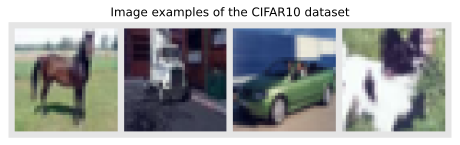

In [15]:
# Visualize some examples
NUM_IMAGES = 4
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [ ]:
train_model(**args, lr=3e-4,)

Files already downloaded and verified
Files already downloaded and verified


Global seed set to 42
Global seed set to 42


Files already downloaded and verified


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name  | Type              | Params
--------------------------------------------
0 | model | VisionTransformer | 3.2 M 
--------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.781    Total estimated model params size (MB)
/Users/albertomarengo/Bitstrapped-Project/PyTorch-Lightning/pytorch-venv/lib/python3.10/site-packages/pytorch_lightning/loggers/tensorboard.py:191: UserWarning: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.
  rank_zero_warn(


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]